In [4]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

In [6]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import tensorflow as tf
tf.__version__

'1.13.0-rc2'

In [2]:
main_dir = '/home/yulia/W266-Final-Project/'

In [13]:
data_path = main_dir+'data/raw/hein-daily'

## Load processed files

In [19]:
outdata_path = main_dir+'Classification/data/splits/gender'

In [20]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)

In [21]:
with open(os.path.join(outdata_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)

In [3]:
token_path = main_dir+'Classification/data/tokenized/gender'

In [7]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [26]:
word_index = pickle.load(open(os.path.join(token_path, 'word_index.p'), 'rb'))

In [8]:
len(train_vec), len(val_vec), len(test_vec)

(188148, 62716, 62716)

## CNN model - Full Speech + Glove Embeddings

In [24]:
logs_base_dir = main_dir + 'Classification/logs/gender'

In [27]:
sepcnn_model_params = {
    'model': 'sepcnn',
    'word_index': word_index,
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'blocks': 2,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 5,
    'pool_size': 3,
    'max_num_words': 20000,
    'use_pretrained_embedding': False,
    'is_embedding_trainable': True
}

In [28]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **sepcnn_model_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 188148 samples, validate on 62716 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 852s - loss: 0.6851 - acc: 0.5214 - val_loss: 0.5937 - val_acc: 0.6881
Epoch 2/1000
 - 841s - loss: 0.5610 - acc: 0.7167 - val_loss: 0.5447 - val_acc: 0.7307
Epoch 3/1000
 - 833s - loss: 0.5133 - acc: 0.7501 - val_loss: 0.5435 - val_acc: 0.7288
Epoch 4/1000
 - 833s - loss: 0.4825 - acc: 0.7680 - val_loss: 0.5443 - val_acc: 0.7317
Epoch 5/1000
 - 833s - loss: 0.4527 - acc: 0.7840 - val_loss: 0.5707 - val_acc: 0.7290
Validation accuracy: 0.7289846539497375, loss: 0.5707138606545359


### Clean up space/save outputs

In [29]:
probs_path = main_dir+'Classification/data/probs/gender/'

In [30]:
np.save(probs_path+'val_pred_probs_sep', val_pred_probs, allow_pickle=True, fix_imports=True)

In [47]:
val_pred_probs = np.load(probs_path+'val_pred_probs_sep.npy', allow_pickle=True, fix_imports=True)

## Model Evaluation

In [31]:
val_preds = val_pred_probs > 0.5
np.mean(val_preds.flatten()==val_target)

0.7289846291217552

In [32]:
val_preds.shape, len(val_target)

((62716, 1), 62716)

In [33]:
sum(val_preds)

array([31205])

Confusion matrix, without normalization
[[22936  8422]
 [ 8575 22783]]
             precision    recall  f1-score   support

       Male       0.73      0.73      0.73     31358
     Female       0.73      0.73      0.73     31358

avg / total       0.73      0.73      0.73     62716



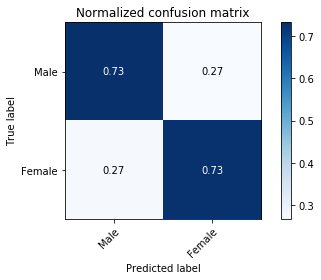

In [34]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

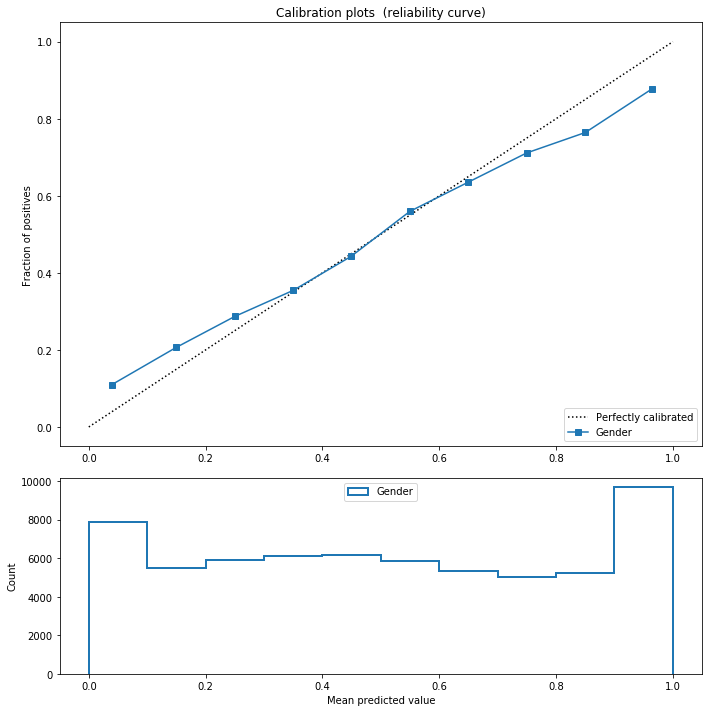

In [35]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [36]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62716, 16)

In [37]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base       0.5        0.17549  58.248453  0.621101   0.659624    392.229001


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.46,0.46,0.99,0.84,0.74,1.02
0.6,1.00,0.89,0.99,0.96,1.12,0.65
1.0,1.54,1.59,1.01,1.17,1.20,1.15


In [38]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
toledos 	 2379.9
shawnee 	 2303.4
overland 	 2264.9
ks 	 2235.6
messrs 	 2082.4
toledo 	 2039.8
eleanor 	 2006.6
west high 	 1976.8
payne of 	 1899.5
south high 	 1816.9


bin,1,2,3,4
eleanor,18.0,14.0,87.0,21.0
ks,38.0,19.0,47.0,71.0
messrs,13.0,2.0,170.0,63.0
overland,7.0,0.0,3.0,23.0
payne of,1.0,1.0,3.0,5.0
shawnee,5.0,0.0,5.0,37.0
south high,2.0,1.0,7.0,8.0
toledo,25.0,7.0,326.0,43.0
toledos,1.0,0.0,22.0,7.0
west high,6.0,0.0,5.0,11.0


In [39]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.93):

date                          20050714
char_count                        5972
word_count                        1103
speakerid                   1.0912e+08
Party                                D
Congress                           109
Chamber                              H
State                               TX
Ethnicity                            B
Age                                 56
Age_lt_med                           1
NonWhite                             1
Female                               1
speaker       Ms. JACKSON-LEE of Texas
Full Name          JACKSON LEE, SHEILA
match                            exact
Name: 1090055372, dtype: object

 Madam Speaker. today I speak about the ravages of war. I also say to my colleagues that there is no claim of being unpatriotic when you desire to speak of peace. The ravages of war can generate much devastation. not only in our domestic society. but also internationally. I rise today. first of all. to